# Evaluation vorticity GCMx -> 2.2km
## Diff model

Vorticity transform: standardize (based on train set mean and std) then devide by standardized train set max

Target transform: sqrt then divide by sqrted train set max

Sample inverse transform: multiply by train set max, clip negative values to 0 then square

In [1]:
%reload_ext autoreload

%autoreload 2

import math
import os

import iris
import iris.analysis.cartography
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from ml_downscaling_emulator import UKCPDatasetMetadata
from ml_downscaling_emulator.helpers import plot_over_ts
from ml_downscaling_emulator.utils import cp_model_rotated_pole, platecarree, plot_grid, open_samples_ds, show_samples

In [2]:
split = "val"
dataset_name = "2.2km-coarsened-gcm-2.2km_london_vorticity850_random"
# gcm_derived_dataset_name = "60km-2.2km_london_vorticity850_random"

run_name = "2.2km-coarsened-gcm_london_vorticity850_random"
checkpoint_id = 17

In [4]:
pred_ds = open_samples_ds(run_name, checkpoint_id, dataset_name, split).isel(sample_id=[0,1])
# gcm_derived_samples_ds = open_samples_ds(run_name, checkpoint_id, gcm_derived_dataset_name, split)
eval_ds = xr.open_dataset(os.path.join(os.getenv("MOOSE_DERIVED_DATA"), "nc-datasets", dataset_name, f"{split}.nc"))

# convert from kg m-2 s-1 (i.e. mm s-1) to mm day-1
pred_ds["pred_pr"] = (pred_ds["pred_pr"]*3600*24 ).assign_attrs({"units": "mm day-1"})
# gcm_derived_samples_ds["pred_pr"] = (gcm_derived_samples_ds["pred_pr"]*3600*24 ).assign_attrs({"units": "mm day-1"})
eval_ds["target_pr"] = (eval_ds["target_pr"]*3600*24).assign_attrs({"units": "mm day-1"})

merged_ds = xr.merge([pred_ds, eval_ds], join="inner")

merged_ds

<xarray.Dataset>
Dimensions:                     (time: 4320, sample_id: 2, bnds: 2,
                                 grid_latitude: 64, grid_longitude: 64)
Coordinates:
  * time                        (time) object 1980-12-03 12:00:00 ... 2080-11...
    forecast_period             (time) timedelta64[ns] 452 days 12:00:00 ... ...
    forecast_reference_time     (time) object 1979-09-01 00:00:00 ... 2059-09...
    realization                 (time) int32 1100000 1100000 ... 1100000 1100000
    season                      (time) int64 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  * grid_latitude               (grid_latitude) float32 -1.58 -1.56 ... -0.32
  * grid_longitude              (grid_longitude) float32 360.9 360.9 ... 362.1
  * sample_id                   (sample_id) int64 0 1
Dimensions without coordinates: bnds
Data variables:
    rotated_latitude_longitude  (sample_id, time) float64 -2.147e+09 ... -2.1...
    time_bnds                   (sample_id, time, bnds) object 1980-12-03 00:...
    grid_latitude_bnds          (sample_id, time, grid_latitude, bnds) float32 ...
    grid_longitude_bnds         (sample_id, time, grid_longitude, bnds) float32 ...
    pred_pr                     (sample_id, time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 4320, 64, 64), meta=np.ndarray>
    forecast_period_bnds        (time, bnds) float64 ...
    target_pr                   (time, grid_latitude, grid_longitude) float32 ...
    vorticity850                (time, grid_latitude, grid_longitude) float64 ...

In [5]:
pred_pr = merged_ds["pred_pr"]
target_pr = merged_ds["target_pr"]

total_pred_pr = merged_ds["pred_pr"].sum(dim=["grid_longitude", "grid_latitude"])
total_target_pr = merged_ds["target_pr"].sum(dim=["grid_longitude", "grid_latitude"])

## Samples

In [6]:
sorted_time = merged_ds.sum(dim=['grid_latitude', 'grid_longitude']).sortby('target_pr')["time"].values
sorted_time

array([cftime.Datetime360Day(2025, 9, 5, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2078, 6, 9, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2038, 4, 26, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.Datetime360Day(2062, 11, 26, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2063, 1, 19, 12, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2033, 11, 19, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)

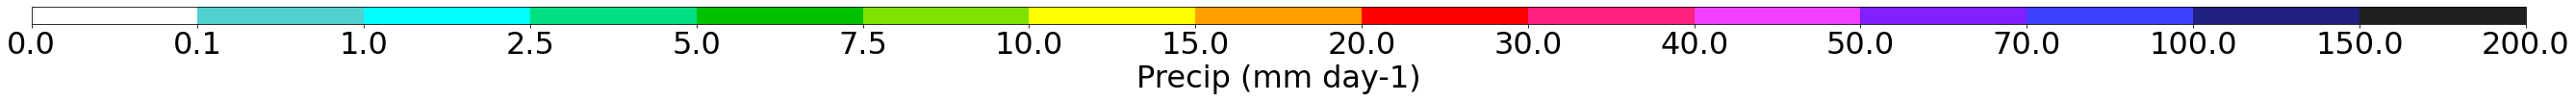

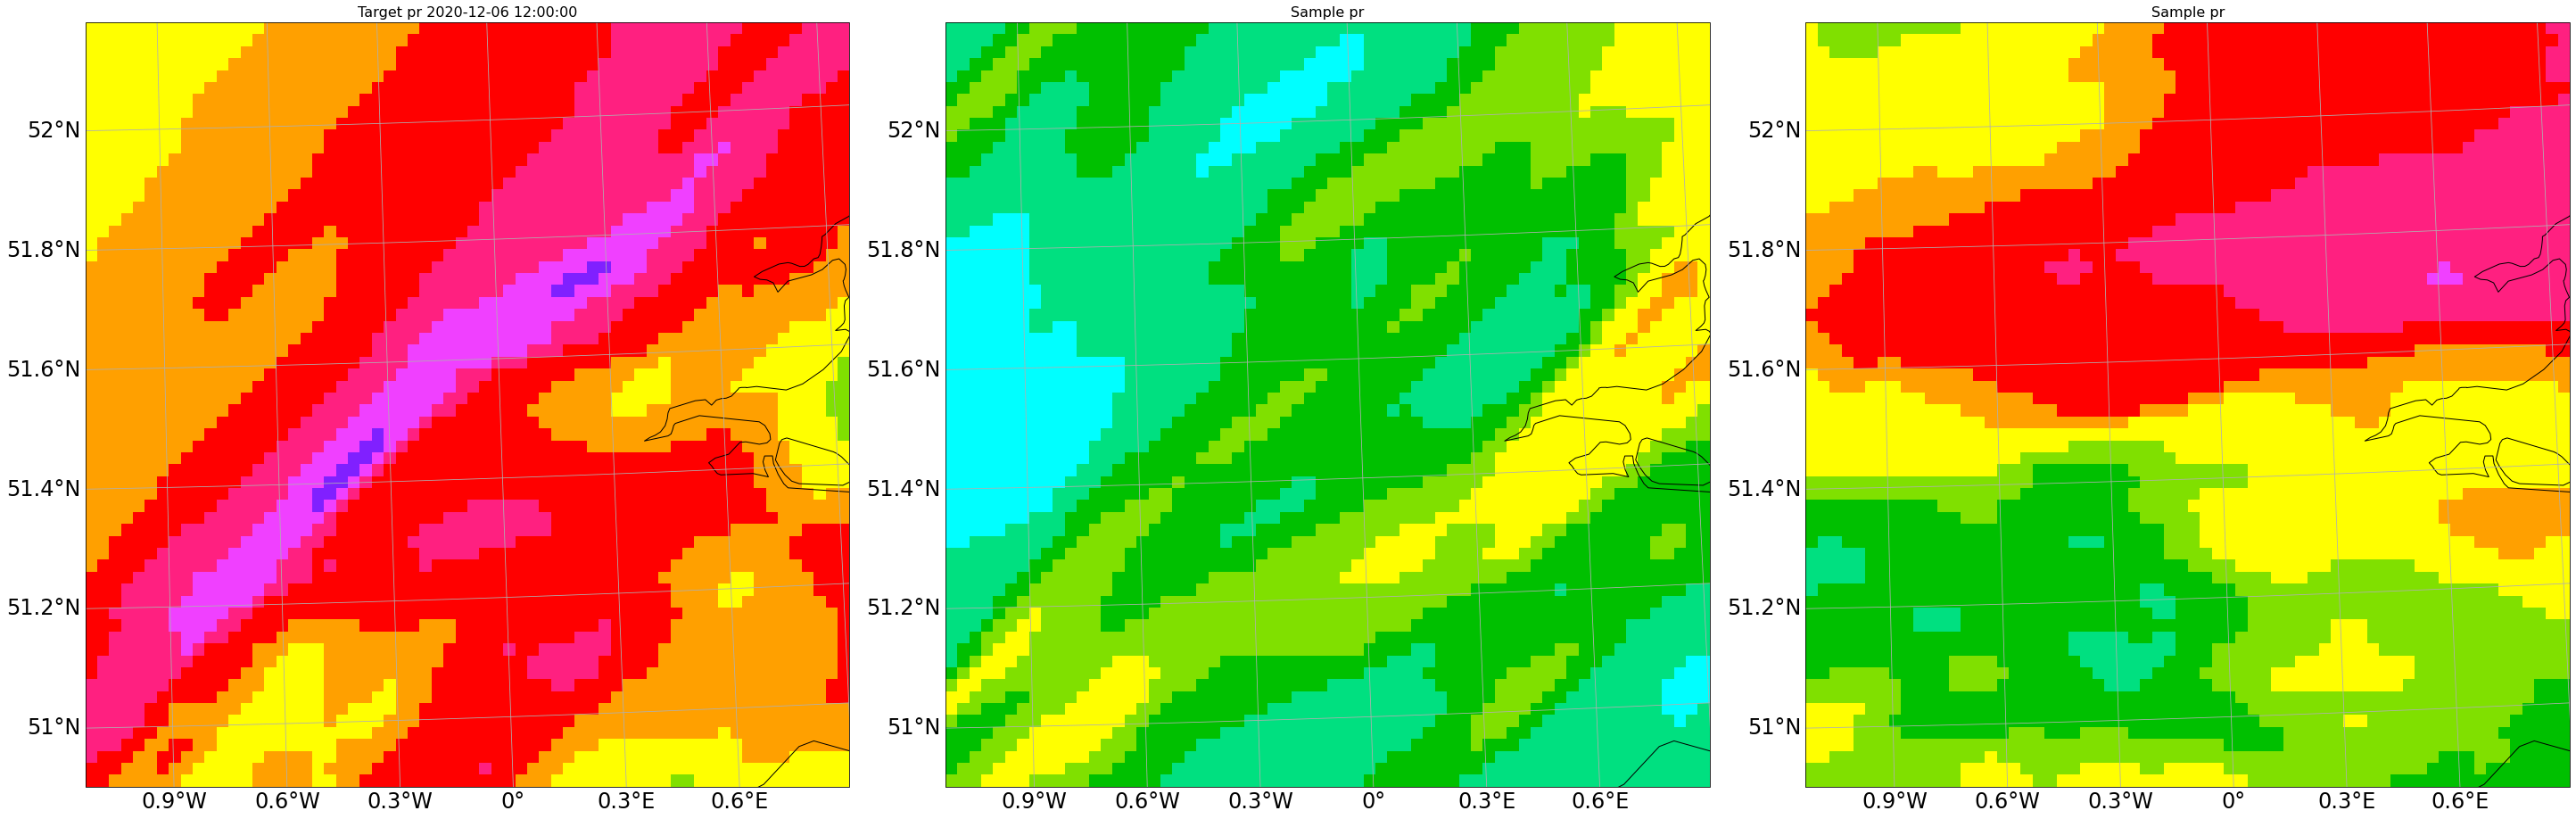

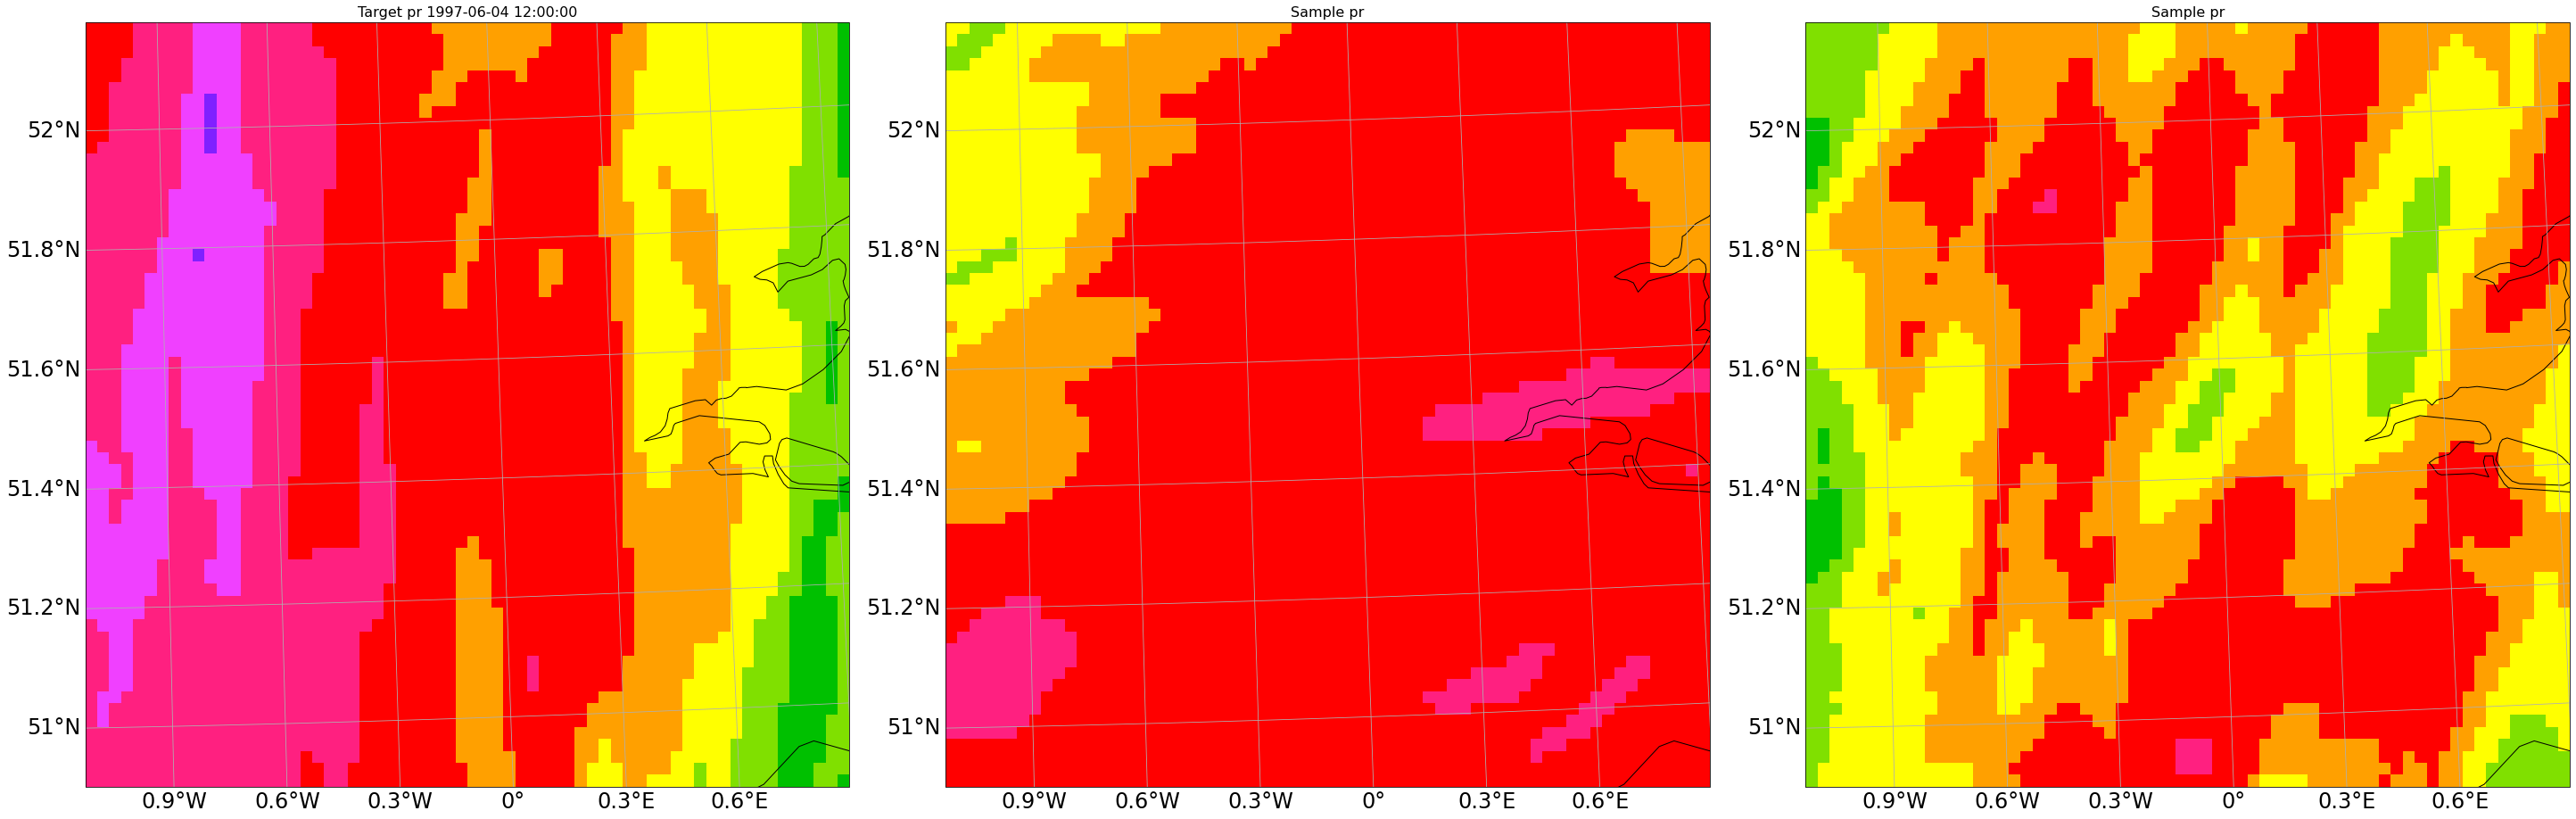

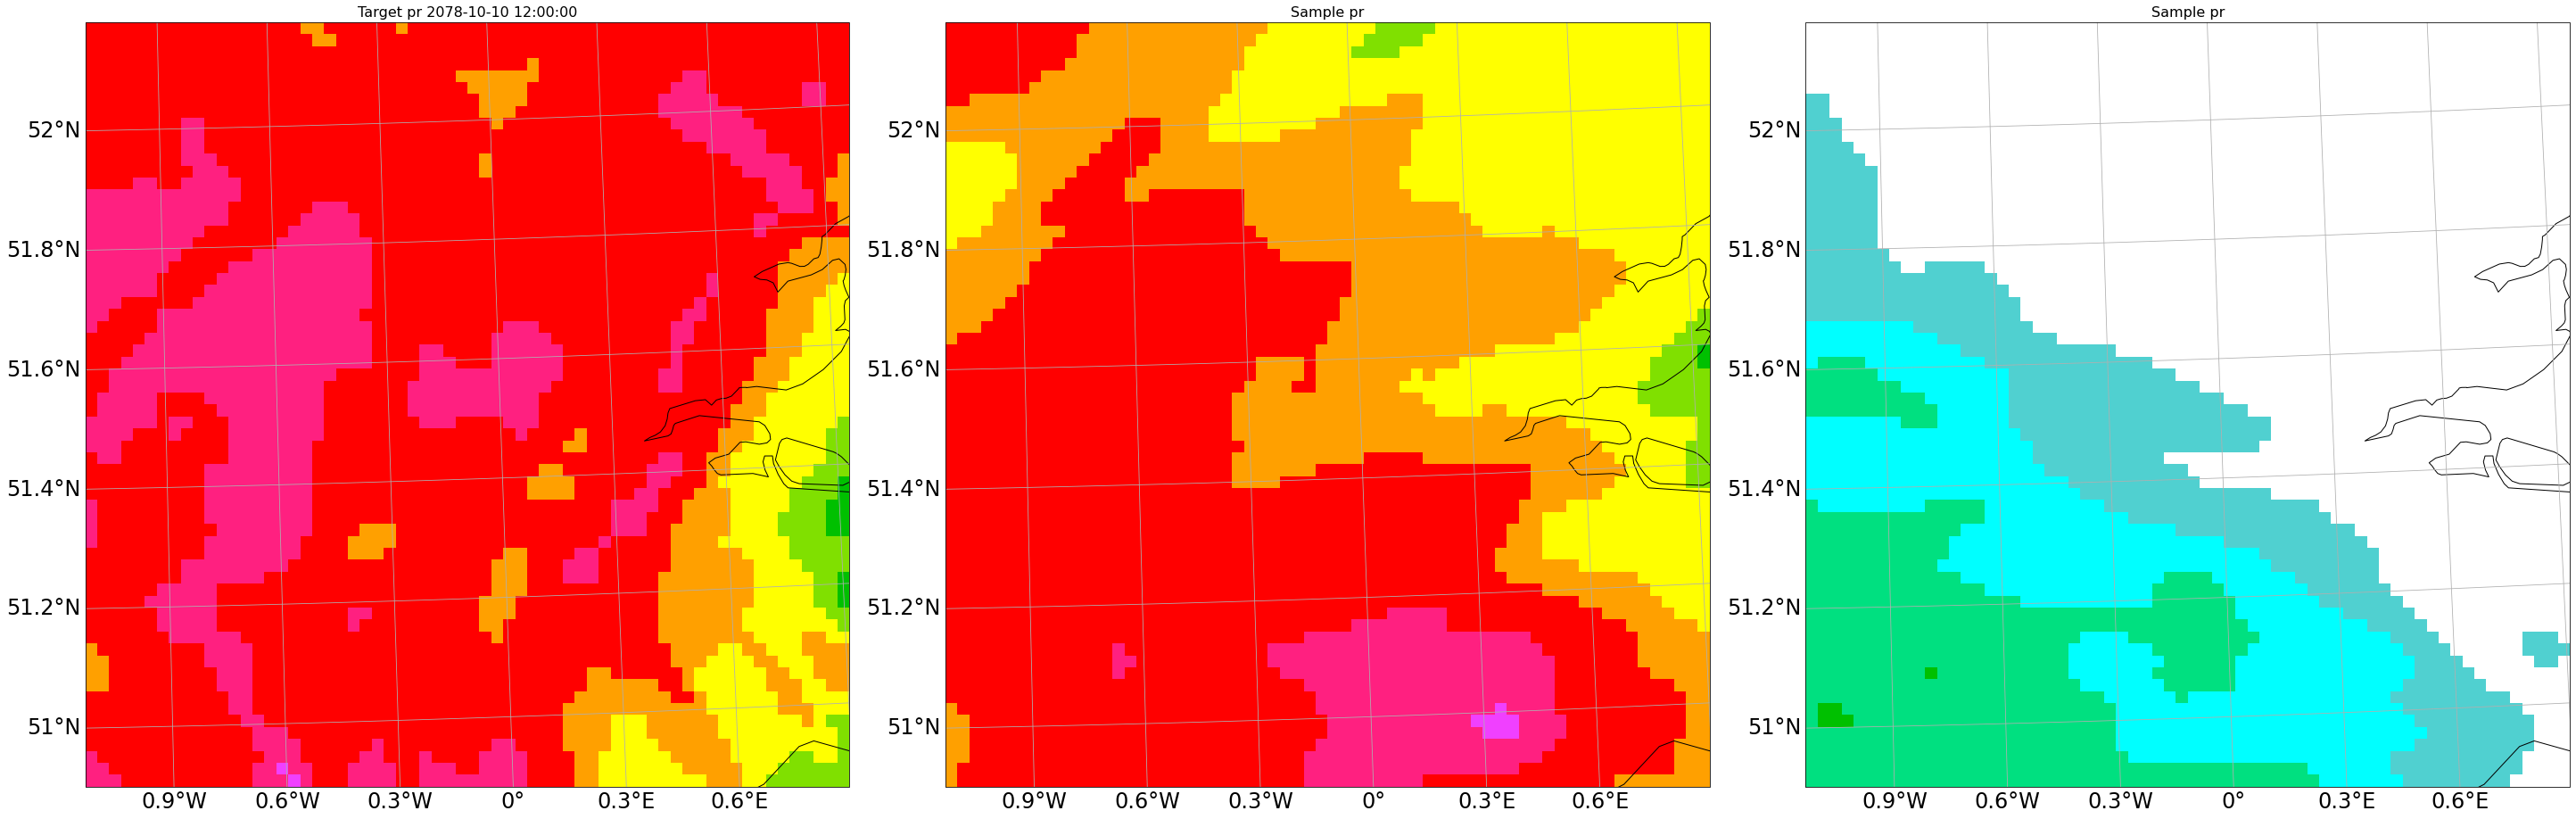

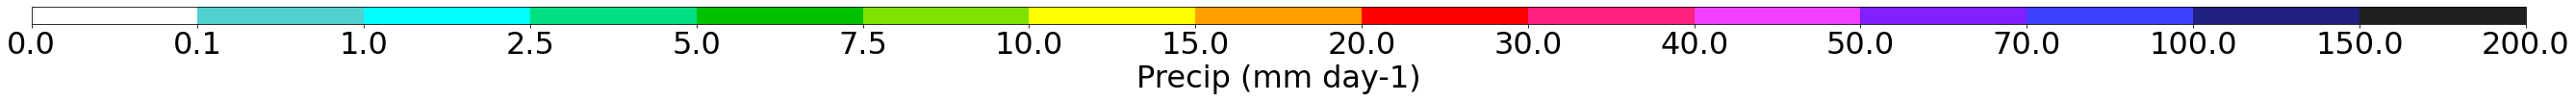

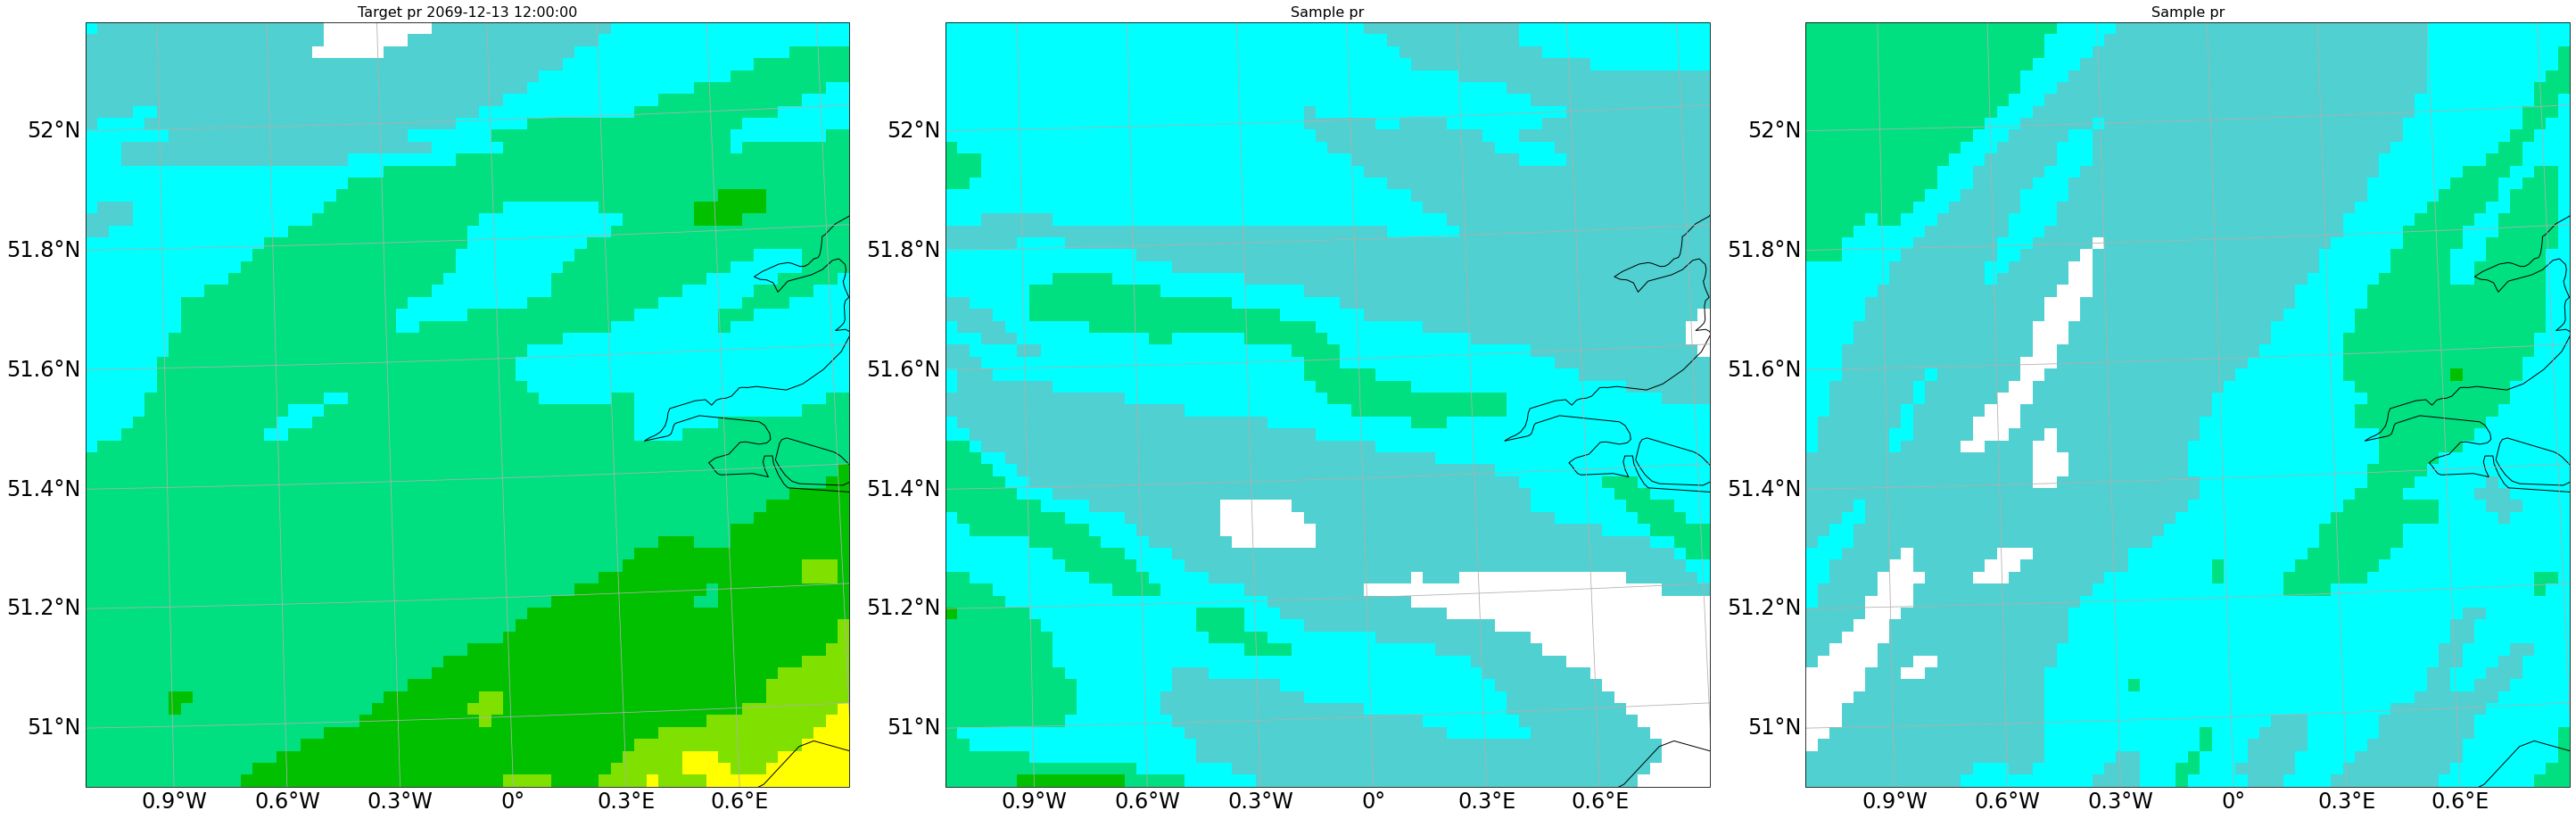

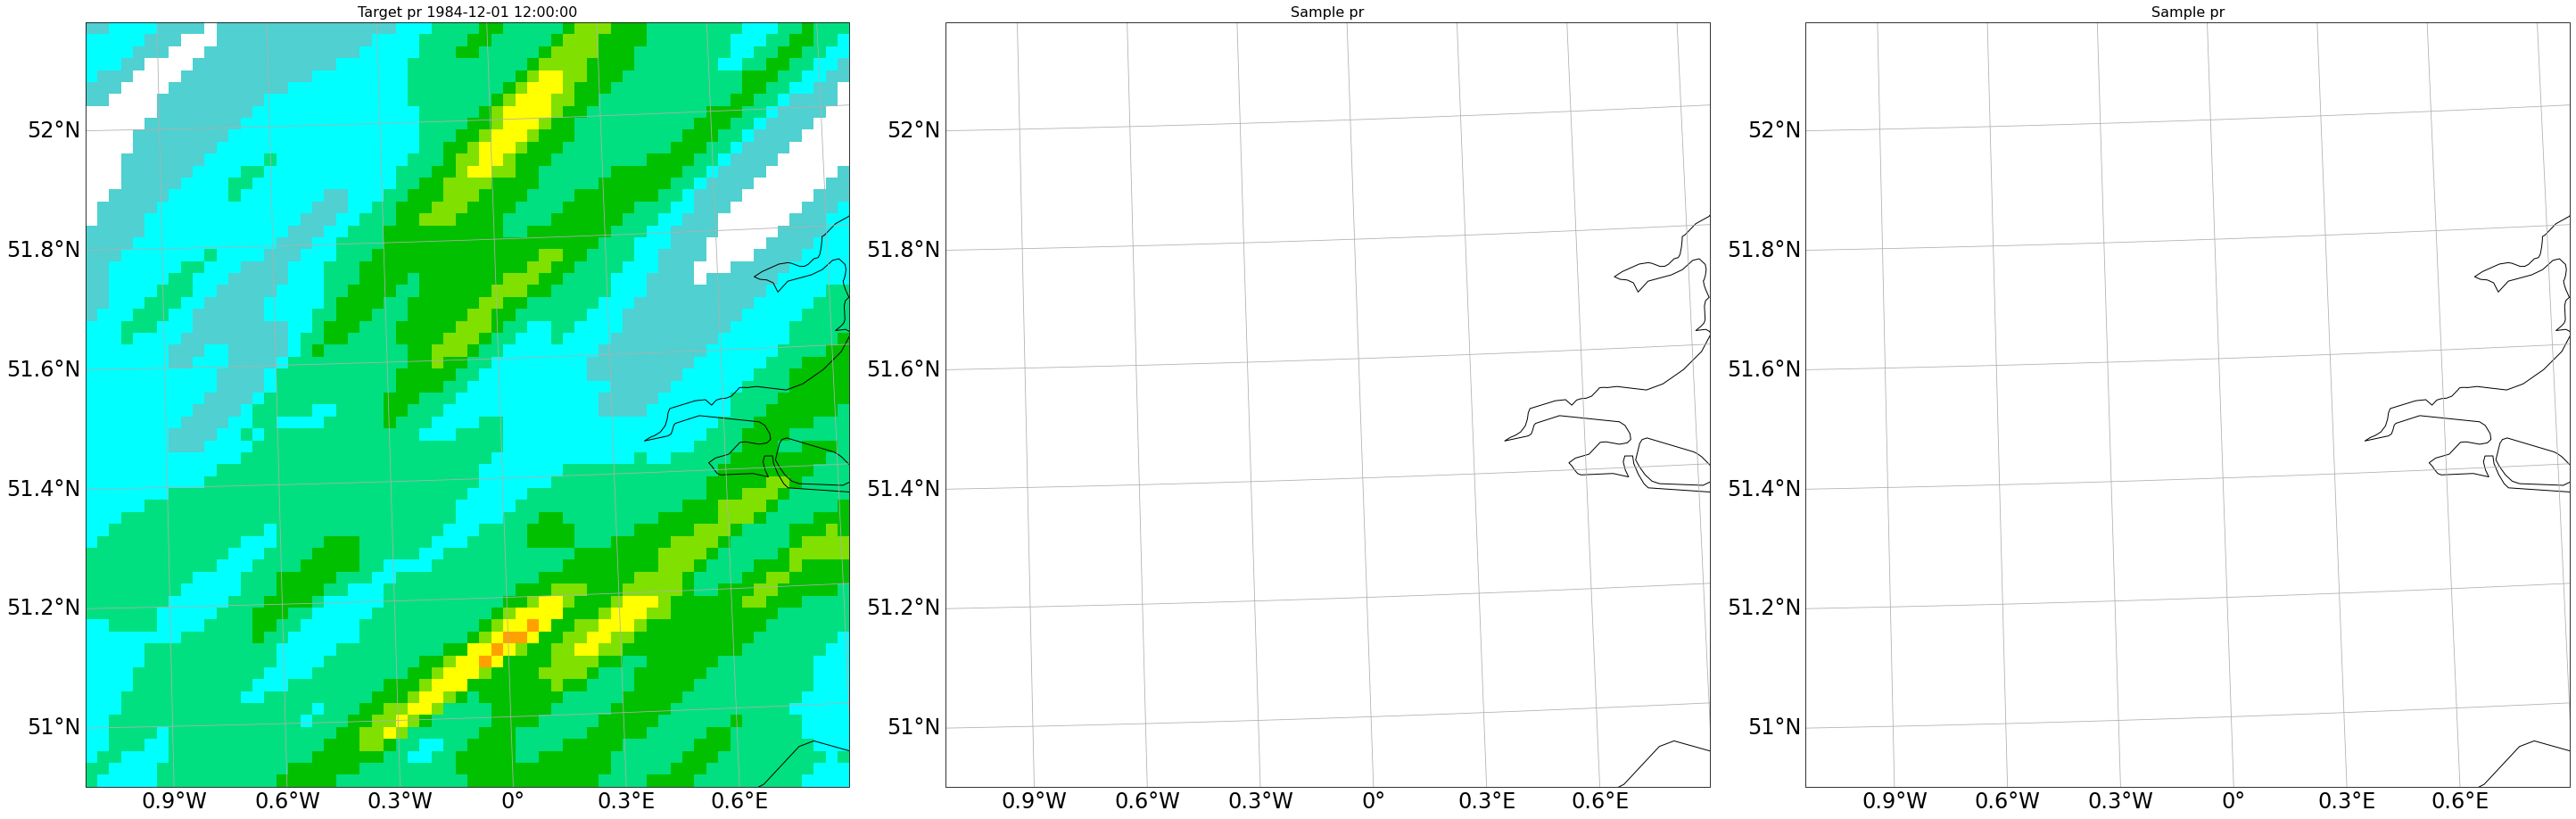

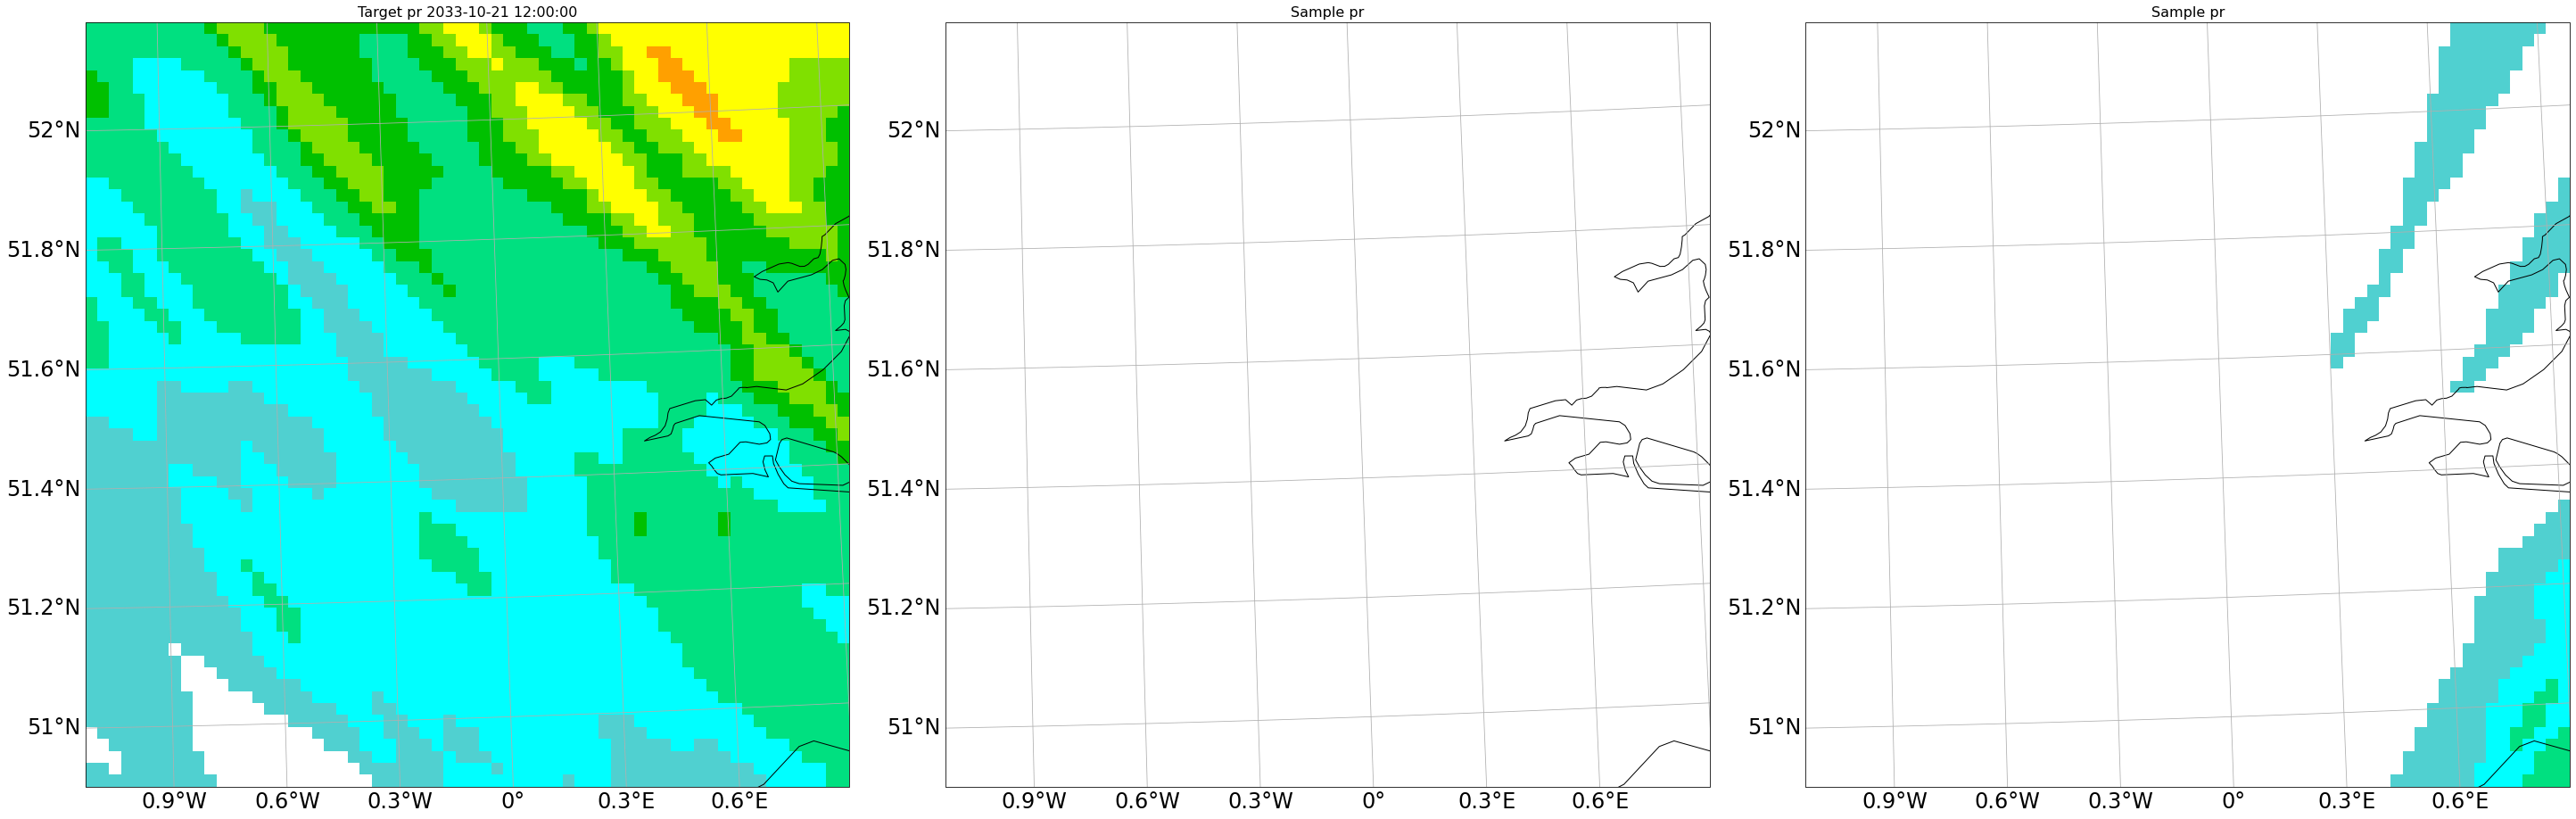

In [7]:
timestamps = np.concatenate([
    sorted_time[t:t+3] for t in [
        -20, 
        # math.ceil(len(sorted_time)*0.9),
        math.ceil(len(sorted_time)*0.81),
        # math.ceil(len(sorted_time)*0.5), 
        # 17
    ]
])
# timestamps = np.random.choice(sorted_time, size=2*3, replace=False)
vmin = 0.5#1e-1*3600*24
vmax = max(merged_ds['pred_pr'].max().values, merged_ds['target_pr'].max().values)
        
show_samples(merged_ds, timestamps, vmin, vmax)

### Pixel

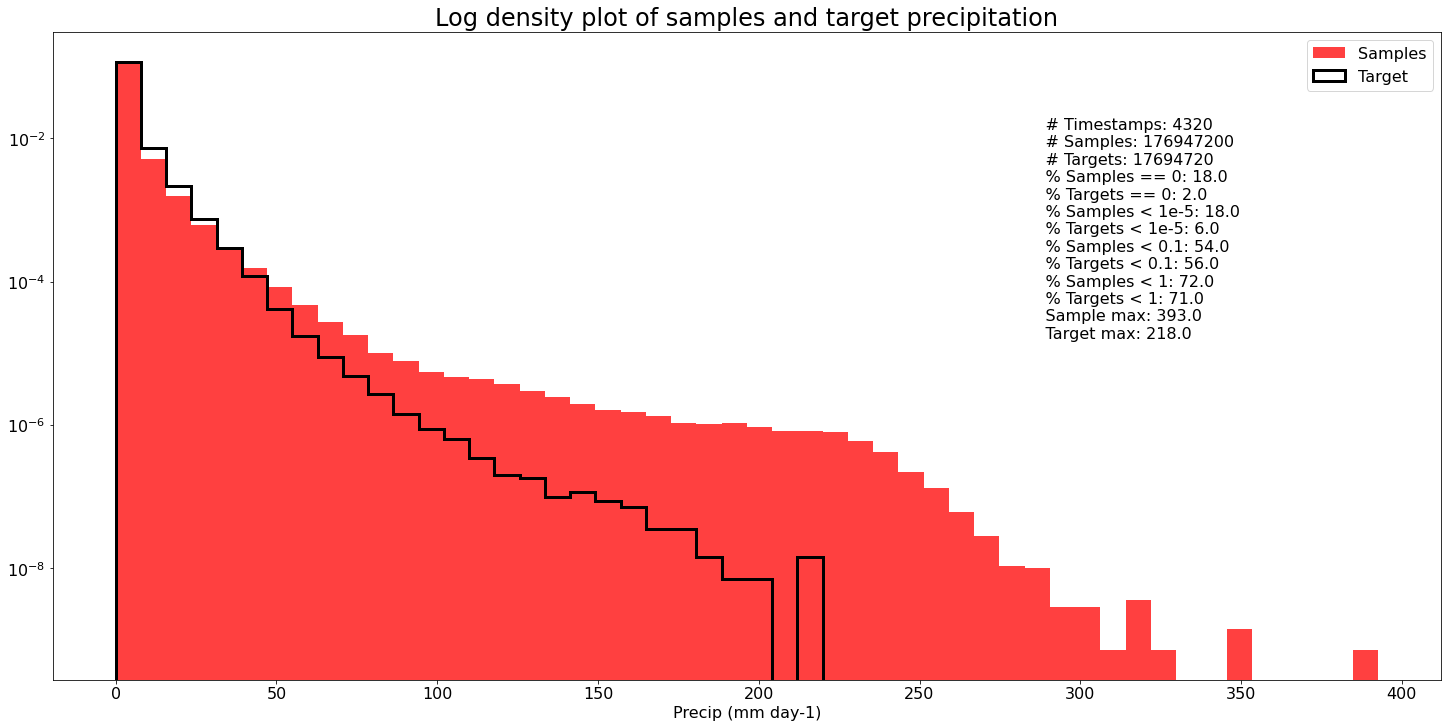

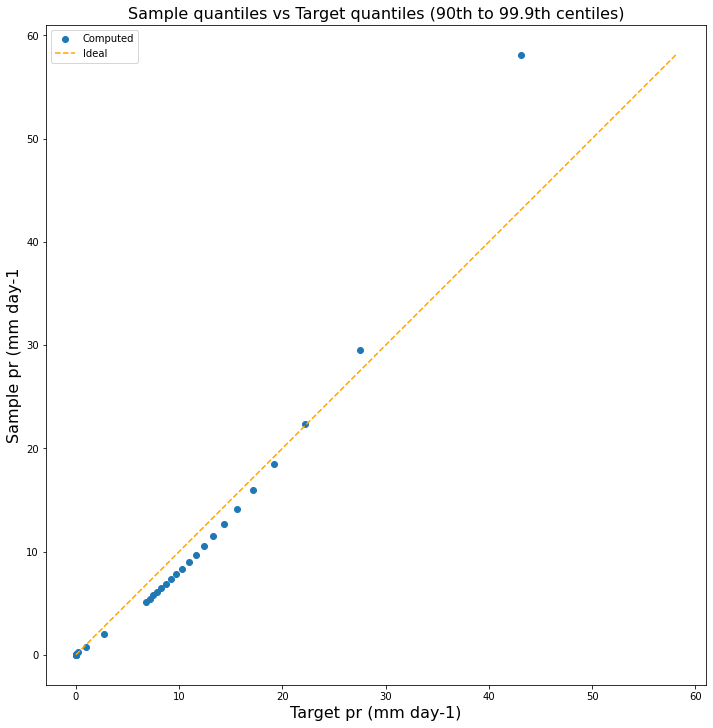

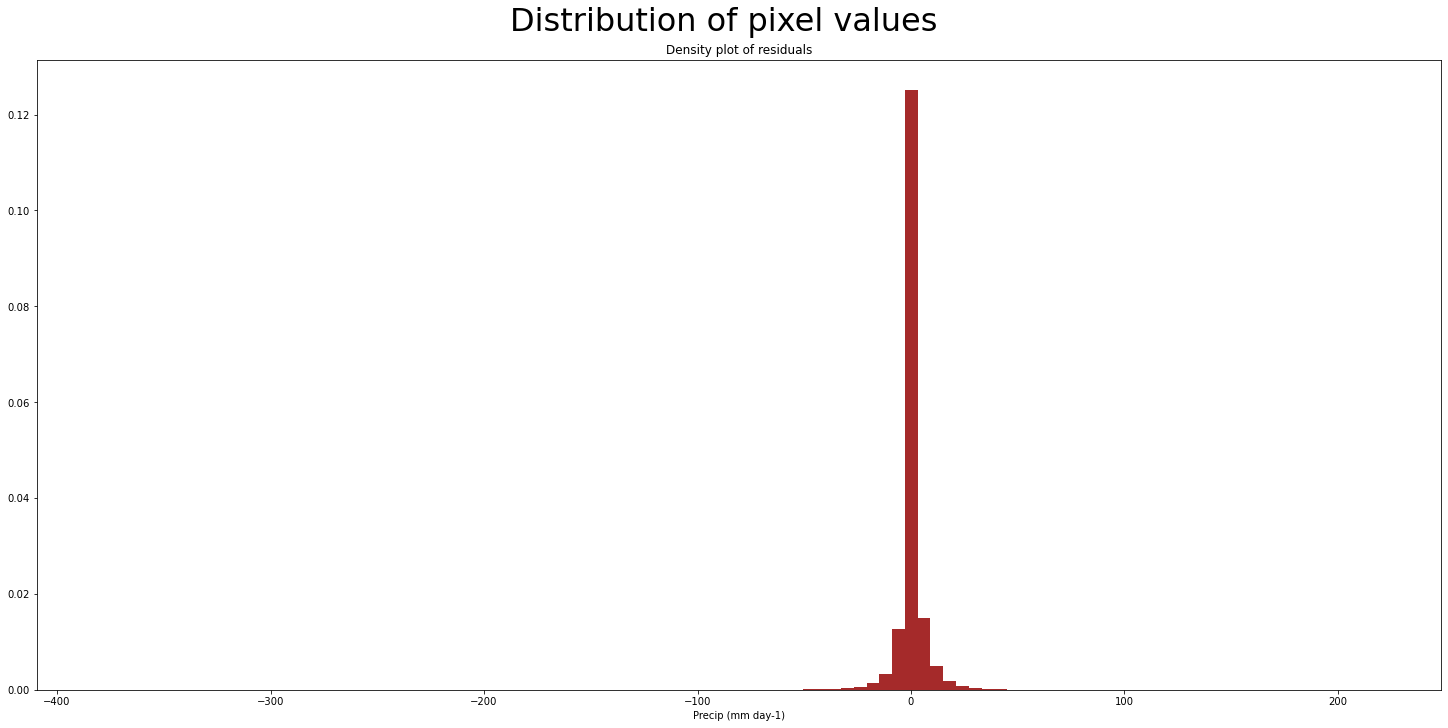

In [9]:
quantiles = np.concatenate([np.linspace(0.1,0.8,8), np.linspace(0.9,0.999,20)])

distribution_figure(target_pr, pred_pr, quantiles, pred_pr.chunk(dict(sample_id=-1)).quantile(0.9999), pred_pr.chunk(dict(sample_id=-1)).quantile(0.99999), "Distribution of pixel values")

### Summed over space

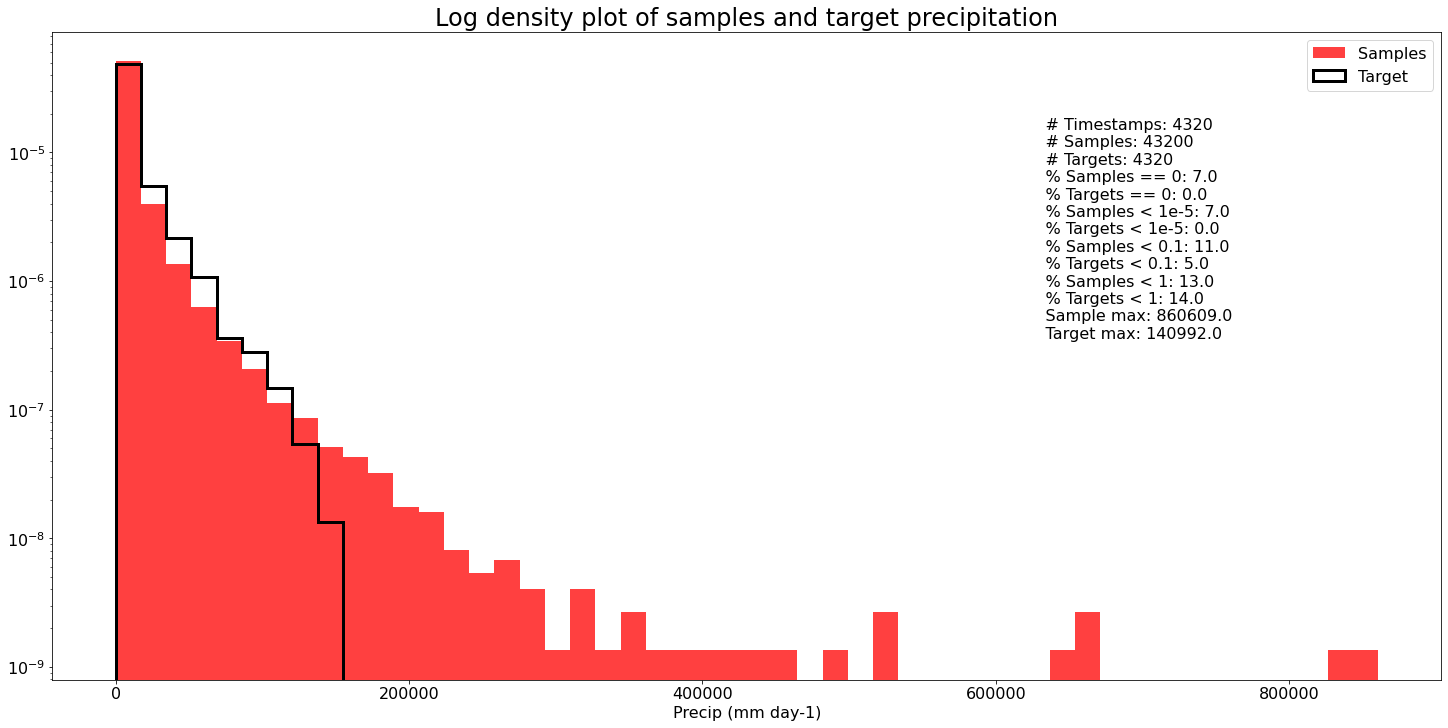

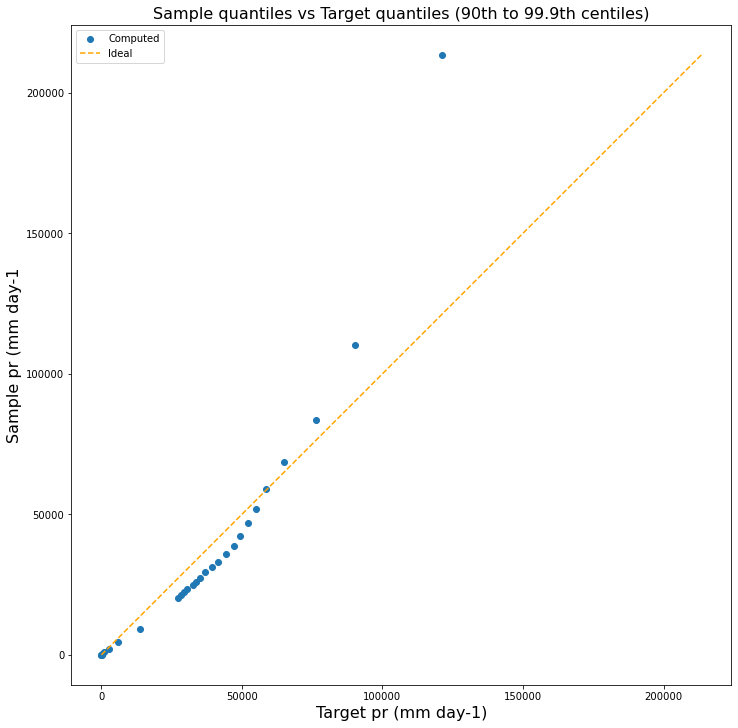

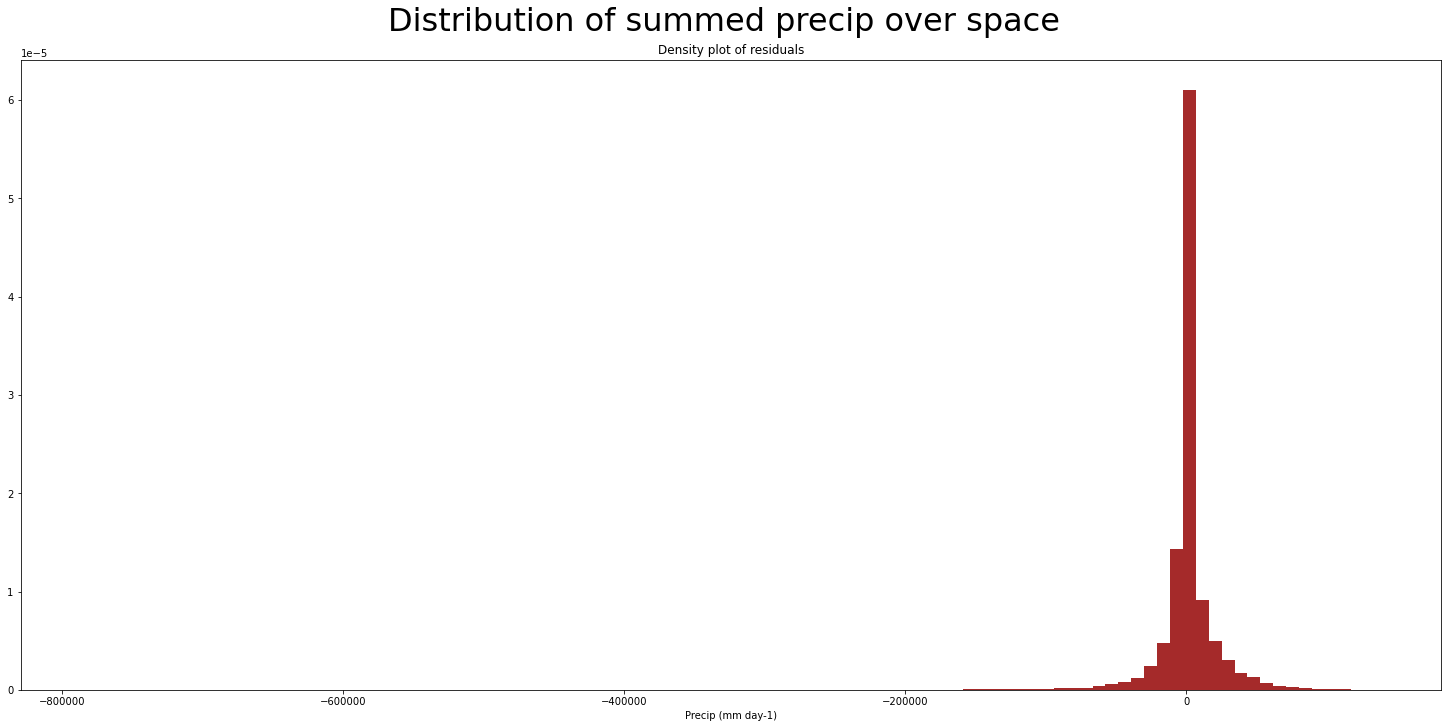

In [10]:
quantiles = np.concatenate([np.linspace(0.1,0.8,8), np.linspace(0.9,0.999,20)])

distribution_figure(total_target_pr, total_pred_pr, quantiles, 1e4, 2e4, "Distribution of summed precip over space")

## Means

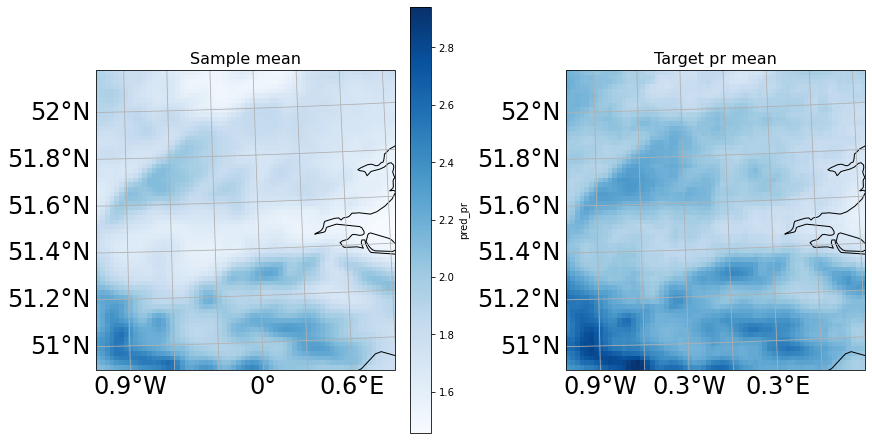

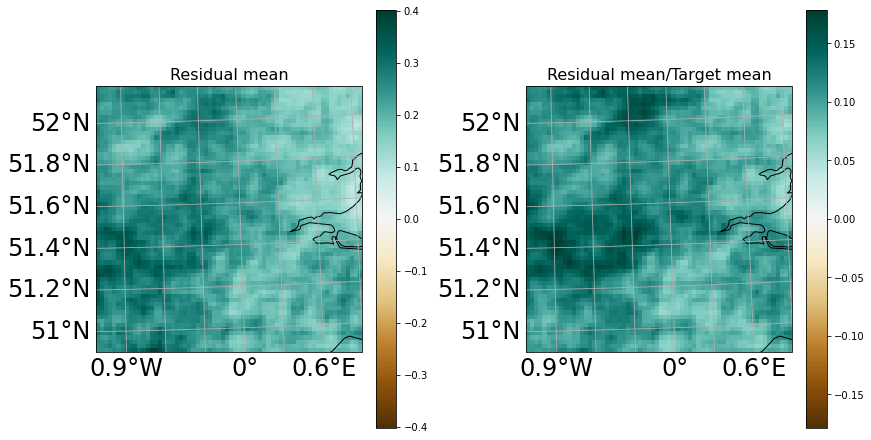

In [11]:
fig, axd = plt.subplot_mosaic([["Sample", "Target"]], figsize=(12, 6), subplot_kw=dict(projection=cp_model_rotated_pole), constrained_layout=True)

sample_mean = merged_ds['pred_pr'].mean(dim=["sample_id", "time"])
target_mean = merged_ds['target_pr'].mean(dim="time")
residuals = merged_ds['target_pr'] - merged_ds['pred_pr']
residual_mean = residuals.mean(dim=["sample_id", "time"])

vmin = min([da.min().values for da in [sample_mean, target_mean]])
vmax = max([da.max().values for da in [sample_mean, target_mean]])

ax = axd["Sample"]
plot_grid(sample_mean, ax, title="Sample mean", norm=None, vmin=vmin, vmax=vmax, add_colorbar=True)

ax = axd["Target"]
plot_grid(target_mean, ax, title="Target pr mean", norm=None, vmin=vmin, vmax=vmax, add_colorbar=False)

plt.show()

fig, axd = plt.subplot_mosaic([["Residual", "Ratio"]], figsize=(12, 6), subplot_kw=dict(projection=cp_model_rotated_pole), constrained_layout=True)

ax = axd["Residual"]
plot_grid(residual_mean, ax, title="Residual mean", norm=None, cmap="BrBG", center=0, add_colorbar=True)

ax = axd["Ratio"]
plot_grid((residual_mean/target_mean), ax, title="Residual mean/Target mean", norm=None, cmap="BrBG", center=0, add_colorbar=True)

plt.show()


## Standard deviation

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6), subplot_kw=dict(projection=cp_model_rotated_pole))

sample_std = merged_ds['pred_pr'].std(dim=["sample_id", "time"])
target_std = merged_ds['target_pr'].std(dim="time")

vmin = min([da.min().values for da in [sample_std, target_std]])
vmax = max([da.max().values for da in [sample_std, target_std]])

ax = axs[0]
plot_grid(sample_std, ax, title="Sample std", norm=None, vmin=vmin, vmax=vmax, add_colorbar=True, cmap="viridis")

ax = axs[1]
plot_grid(target_std, ax, title="Target pr std", norm=None, vmin=vmin, vmax=vmax, add_colorbar=True, cmap="viridis")

ax = axs[2]
plot_grid((sample_std/target_std), ax, title="Sample/Target pr std", norm=None, cmap="BrBG", center=1, add_colorbar=True)

plt.show()


KeyboardInterrupt



## Scatter

In [ ]:
# fig, axs = plt.subplots(1, 1, figsize=(20, 6))

# tr = min(merged_ds["pred_pr"].max(), merged_ds["target_pr"].max())


# ax = axs

# ax.scatter(x=merged_ds["pred_pr"], y=merged_ds["target_pr"].values[None, :].repeat(len(merged_ds["sample_id"]), 0), alpha=0.05)
# ax.plot([0, tr], [0, tr], linewidth=1, color='green')


In [ ]:
# sample_ids = np.arange(9).reshape(3, 3)

# fig, axs = plt.subplots(sample_ids.shape[0], sample_ids.shape[1], figsize=(30, 12))

# tr = min(merged_ds["pred_pr"].max(), merged_ds["target_pr"].max())

# for i, sample_id in enumerate(sample_ids.flatten()):
#     ax = axs[i//3][i%3]

#     ax.scatter(x=merged_ds["pred_pr"].sel(sample_id=sample_id), y=merged_ds["target_pr"], alpha=0.1)
#     ax.plot([0, tr], [0, tr], linewidth=1, color='green')
#     ax.set_xlabel(f"Sample {sample_id} pr")
#     ax.set_ylabel(f"Target pr")
    
# plt.show()

In [ ]:
# fig, axs = plt.subplots(1, 1, figsize=(20, 6))

# tr = min(total_pred_pr.max(), total_target_pr.max())

# ax = axs

# ax.scatter(x=total_pred_pr, y=total_target_pr.values[None, :].repeat(len(total_pred_pr["sample_id"]), 0), alpha=0.25)
# ax.plot([0, tr], [0, tr], linewidth=1, color='green')

# plt.show()

## PSD

In [ ]:
import pysteps

In [ ]:
pysteps.utils.spectral.rapsd(merged_ds["target_pr"].isel(time=0).values)

## Correlation

In [11]:
target_corr = xr.corr(merged_ds["vorticity850"], merged_ds["target_pr"], dim="time")
sample_corr = xr.corr(merged_ds["vorticity850"], merged_ds["pred_pr"], dim="time").mean(dim="sample_id")

In [ ]:
fig, axd = plt.subplot_mosaic([["Sample", "Target"]], figsize=(12, 6), subplot_kw=dict(projection=cp_model_rotated_pole), constrained_layout=True)

ax = axd["Sample"]
plot_grid(sample_corr, ax, title="Sample corr", norm=None, cmap="RdBu", centre=0, add_colorbar=True)

ax = axd["Target"]
plot_grid(target_corr, ax, title="Target corr", norm=None, cmap="RdBu", center=0, add_colorbar=True)